# Graph Prediction Model
In this notebook, we run through an experiment using UserALE data generated within an instantiation of Superset.  This data reflects four simulated user sessions in which the user performs three tasks within the Video Game Sales example dashboard:

1. Filter the games for Wii, Racing, and Nintendo.
2. Find Mario Kart in the list of games.
3. Determine the difference in global sales between the 3DS game Nintendogs + cats and Wii Sports.

The data of these four sessions is captured in a json file within the data folder entitled `task_example.json`.  In this experiment, we will:

* Experiment with the efficacy of several predictive models to determine which is the best for our objective
* Attempt to plug the `DiGraph` objects resulting from `task_example.json` into the model we choose
* Tune the resulting model to minimize loss and maximize prediction accuracy

**Note: The data utilized in this example was not data collected in any user study.  Rather this data is simulated through developer interactions with the Superset dashboard.**

# Legacy Code:

Generates the graph lists and structures that we'll eventually use for reference.

In [1]:
import sys
sys.path.append('../')

import datetime
import distill
import json
import networkx as nx
import os
import pandas as pd
import plotly.express as px
import re

def setup(file, date_type):
    with open(file) as json_file:
        raw_data = json.load(json_file)

    data = {}
    for log in raw_data:
        data[distill.getUUID(log)] = log
        
    # Convert clientTime to specified type
    for uid in data:
        log = data[uid]
        client_time = log['clientTime']
        if date_type == "integer":
            log['clientTime'] = distill.epoch_to_datetime(client_time)
        elif date_type == "datetime":
            log['clientTime'] = pd.to_datetime(client_time, unit='ms', origin='unix')

    # Sort
    sorted_data = sorted(data.items(), key=lambda kv: kv[1]['clientTime'])
    sorted_dict = dict(sorted_data)

    return (sorted_data, sorted_dict)

def draw_digraph(segments):
    nodes = sorted(segments.get_segment_list(), key=lambda segment: segment.start_end_val[0])
    edges = distill.pairwiseSeq(segments.get_segment_list())
    
    # Set coloring of graph based on element in Superset dashboard
    color_map = []
    for segment in segments:
        if re.match("Game_Filter\S*", segment.segment_name):
            color_map.append('green')
        else:
            color_map.append('blue')
    
    graph = distill.createDiGraph(nodes, edges)
    nx.draw(graph, node_color=color_map)
    return graph

In [2]:
data_many_session = setup("./data/task_example.json", "datetime")
sorted_dict = data_many_session[1]

# Create segments based on sessionID
segments = distill.Segments()
session_ids = sorted(distill.find_meta_values('sessionID', sorted_dict), key=lambda sessionID: sessionID)
for session_id in session_ids:
    segments.append_segments(distill.generate_collapsing_window_segments(sorted_dict, 'sessionID', [session_id], session_id))
    
# Improve readability of Segment names
for index in range(len(segments)):
    segments[index].segment_name = "Session" + str(index)
    
    
segment_names = [segment.segment_name for segment in segments]
start_end_vals = [segment.start_end_val for segment in segments]
segment_map = distill.write_segment(sorted_dict, segment_names, start_end_vals)

session_0_segments = distill.generate_collapsing_window_segments(segment_map['Session0'], 'path', ['div.filter-container css-ffe7is'], "Game_Filter")
session_1_segments = distill.generate_collapsing_window_segments(segment_map['Session1'], 'path', ['div.filter-container css-ffe7is'], "Game_Filter")
session_2_segments = distill.generate_collapsing_window_segments(segment_map['Session2'], 'path', ['div.filter-container css-ffe7is'], "Game_Filter")
session_3_segments = distill.generate_collapsing_window_segments(segment_map['Session3'], 'path', ['div.filter-container css-ffe7is'], "Game_Filter")

session_0_segments.append_segments(distill.generate_collapsing_window_segments(segment_map['Session0'], 'path', ['div#chart-id-110.superset-chart-table'], "Games"))
session_1_segments.append_segments(distill.generate_collapsing_window_segments(segment_map['Session1'], 'path', ['div#chart-id-110.superset-chart-table'], "Games"))
session_2_segments.append_segments(distill.generate_collapsing_window_segments(segment_map['Session2'], 'path', ['div#chart-id-110.superset-chart-table'], "Games"))
session_3_segments.append_segments(distill.generate_collapsing_window_segments(segment_map['Session3'], 'path', ['div#chart-id-110.superset-chart-table'], "Games"))

segments.append_segments(session_0_segments)
segments.append_segments(session_1_segments)
segments.append_segments(session_2_segments)
segments.append_segments(session_3_segments)

**Example user-activity graph:**

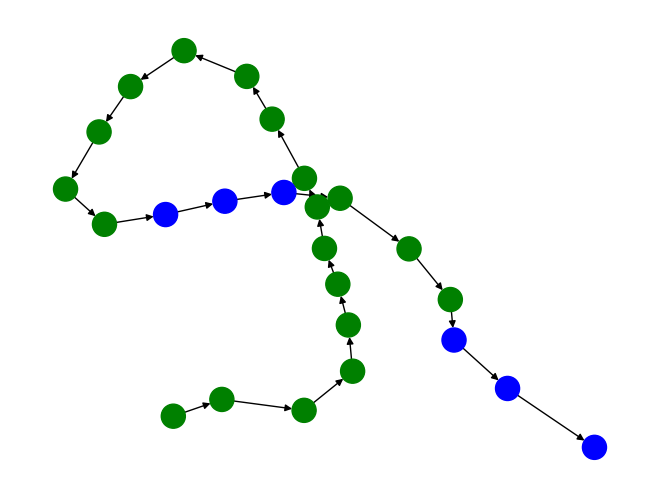

In [3]:
G0 = draw_digraph(session_0_segments)

# GAN Research / Fooling Around:

Source code found at https://towardsdatascience.com/build-a-super-simple-gan-in-pytorch-54ba349920e4

Very basic task: Training a GAN to generate positive integers using vectors of their binary encodings (Ex: 56 is 0111000)

In [4]:
from typing import List
from typing import Tuple
import math

def create_binary_list_from_int(number: int) -> List[int]:
    if number < 0 or type(number) is not int:
        raise ValueError("Only Positive integers are allowed")

    return [int(x) for x in list(bin(number))[2:]]

def generate_even_data(max_int: int, batch_size: int=16) -> Tuple[List[int], List[List[int]]]:
    # Get the number of binary places needed to represent the maximum number
    max_length = int(math.log(max_int, 2))

    # Sample batch_size number of integers in range 0-max_int
    sampled_integers = np.random.randint(0, int(max_int / 2), batch_size)

    # create a list of labels all ones because all numbers are even
    labels = [1] * batch_size

    # Generate a list of binary numbers for training.
    data = [create_binary_list_from_int(int(x * 2)) for x in sampled_integers]
    data = [([0] * (max_length - len(x))) + x for x in data]

    return labels, data

**Building the Generator:**

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):

    def __init__(self, input_length: int):
        super(Generator, self).__init__()
        self.dense_layer = nn.Linear(int(input_length), int(input_length))
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.dense_layer(x))

**Building the Discriminator**

In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_length: int):
        super(Discriminator, self).__init__()
        self.dense = nn.Linear(int(input_length), 1);
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.dense(x))

**Training**

In [7]:
import numpy as np

def train(max_int: int = 128, batch_size: int = 16, training_steps: int = 201):
    input_length = int(math.log(max_int, 2))

    # Models
    generator = Generator(input_length)
    discriminator = Discriminator(input_length)

    # Optimizers
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)

    # loss
    loss = nn.BCELoss()

    for i in range(training_steps):
        # zero the gradients on each iteration
        generator_optimizer.zero_grad()

        # Create noisy input for generator
        # Need float type instead of int
        noise = torch.randint(0, 2, size=(batch_size, input_length)).float()
        generated_data = generator(noise)
        
        # Generate examples of even real data
        true_labels, true_data = generate_even_data(max_int, batch_size=batch_size)
        true_labels = torch.tensor(true_labels).unsqueeze(1).float()
        true_data = torch.tensor(true_data).float()

        # Train the generator
        # We invert the labels here and don't train the discriminator because we want the generator
        # to make things the discriminator classifies as true.
        generator_discriminator_out = discriminator(generated_data)
        generator_loss = loss(generator_discriminator_out, true_labels)
        generator_loss.backward()
        generator_optimizer.step()
        # Print generator's loss at every 50th step
        if (i % 50)==0 :
          print("STEP ", str(i))
          print(generator_loss)

        # Train the discriminator on the true/generated data
        discriminator_optimizer.zero_grad()
        true_discriminator_out = discriminator(true_data)
        true_discriminator_loss = loss(true_discriminator_out, true_labels)

        # add .detach() here think about this
        z = torch.zeros(batch_size).unsqueeze(1)
        generator_discriminator_out = discriminator(generated_data.detach())
        generator_discriminator_loss = loss(generator_discriminator_out, z)
        discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
        discriminator_loss.backward()
        discriminator_optimizer.step()

In [8]:
train()

STEP  0
tensor(0.6013, grad_fn=<BinaryCrossEntropyBackward0>)
STEP  50
tensor(0.6424, grad_fn=<BinaryCrossEntropyBackward0>)
STEP  100
tensor(0.6467, grad_fn=<BinaryCrossEntropyBackward0>)
STEP  150
tensor(0.6380, grad_fn=<BinaryCrossEntropyBackward0>)
STEP  200
tensor(0.6332, grad_fn=<BinaryCrossEntropyBackward0>)


So essentially what we'd do for the graphs is, instead of feeding integers, we would feed session data. Feature vectors would represent [div_1, div_2, ..., div_n] with each element denoting whether or not an element was clicked at that segment of the session (vertex of the graph). Only problem is, human-made session data is not so easily generated as it is with random numbers in this example.

**Summary so far:**

So far, I've read:
* (GAN theory) https://www.frontiersin.org/articles/10.3389/fdata.2019.00003/full
* (undirected graphs GAN with tensorflow) https://github.com/hwwang55/GraphGAN (further documentation: https://arxiv.org/pdf/1711.08267.pdf)
* (directed graphs GAN with pytorch) https://github.com/THUDM/GraphSGAN (further documentation: https://arxiv.org/pdf/1809.00130.pdf)

As a result, I have a good idea of the theory and am currently working out how to reverse-engineer the third link which looks most promising. All my notes on this are currently in a word doc.

**Current Problems:**
* A GAN typically requires 50,000-100,000 images/graphs to train on, and we only have 4 graphs in the example
* Having a hard time percieving the third link's input data and how to translate ours to fit its format

**Questions:**
* How accurate would we want our GAN generator to be? (loss-wise)
* Realistically, how many training sessions can we get beyond the 4 that exist in the example json?
* Might be possible to generate the data in a way that doesn't require ML. Maybe through bots or something? Do we want the session data to strictly reflect the behavior of human users?
* What are we looking for in our model? For it to know a typical series of clicks that the average user might generate? In this case, should we consider an ngram-style neural network we could use as a sequence generator (replacing words with segments), instead?

**Input:**
* Stop working on GANs. Too much data is required for training.
* Start working on ngram NN
* Essentially: Predict the next graph in a series of graphs by averaging the past ones
* Purpose: Predicting future user activity based on their past activity. But for now, we will be using the activity of multiple users to predict future activity of the average user
* Aside: If it so happens that our model does not train well, there’s a chance it’s because the data we’re using is flawed. Inform them of this.


# Ngram NN Research / Fooling Around:

In [31]:
segments = session_0_segments
nodes = sorted(segments.get_segment_list(), key=lambda segment: segment.start_end_val[0])
edges = distill.pairwiseSeq(segments.get_segment_list())
print( nodes[24].get_segment_uids() )
print( nodes[24].get_segment_name() )
print( nodes[24].get_generate_field_name() )
print( len(nodes) )

['session_16527363465571652736427217rawmouseover', 'session_16527363465571652736427318rawscroll', 'session_16527363465571652736428683rawmouseover', 'session_16527363465571652736428699rawmouseover', 'session_16527363465571652736428763rawmouseover', 'session_16527363465571652736428909rawwheel', 'session_16527363465571652736428921rawscroll', 'session_16527363465571652736429603rawmouseover', 'session_16527363465571652736429779rawmouseover', 'session_16527363465571652736429835rawmouseover', 'session_16527363465571652736430013rawmouseover', 'session_16527363465571652736430117rawmouseover', 'session_16527363465571652736433401rawmouseover', 'session_16527363465571652736433433rawmouseover', 'session_16527363465571652736433465rawmouseover', 'session_16527363465571652736434235rawmouseover', 'session_16527363465571652736434331rawmouseover', 'session_16527363465571652736436417rawmouseover', 'session_16527363465571652736436433rawmouseover']
Games5
path
25
